<a href="https://colab.research.google.com/github/Josephjiao7/Geographical-Gaussian-Process-Regression/blob/main/GGPR_ESDA_Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install shap geoshapley

In [3]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, StationaryKernelMixin, NormalizedKernelMixin, Matern
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_val_score
import geopandas as gpd
import geoshapley
from geoshapley import GeoShapleyExplainer
import warnings
warnings.filterwarnings("ignore")

class SpatialSimilarityKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self, P_function, sigma_values, epsilon=0.0001):
        self.P_function = P_function
        self.sigma_values = sigma_values
        self.epsilon = epsilon

    def _calculate_similarity(self, u, v):
        u = u[:, np.newaxis, :]
        v = v[np.newaxis, :, :]
        sq_diff = (u - v) ** 2
        E_i = np.exp(-((sq_diff) / (2 * (self.sigma_values**2))))
        return E_i

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        E_i = self._calculate_similarity(X, Y)
        S_uv = np.average(E_i, axis=2, weights=self.P_function)
        return S_uv

    def diag(self, X):
        return np.diag(np.ones(X.shape[0])) + self.epsilon

    def is_stationary(self):
        return True

# Define the objective function for Bayesian optimization
def objective(params):
    P_function = np.concatenate((params['P_function'], [0, 0]))
    length_scale = params['length_scale']
    nu = params['nu']
    w = params['w']

    similarity_kernel = SpatialSimilarityKernel(P_function=P_function, sigma_values=sigma_values)
    kernel = similarity_kernel + w * Matern(length_scale=length_scale, nu=nu)

    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-1, optimizer=None) # We recommend that users set the alpha value to 1e-1
    neg_rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    scores = cross_val_score(gpr, X, y, scoring=neg_rmse_scorer, cv=5)

    loss = -np.mean(scores)
    return {'loss': loss, 'status': STATUS_OK}

# Load data
chicago = gpd.read_file("/data/chicago.geojson")
chicago['pct_white'] = 1-chicago['pct_nonwhi']
chicago['PD_log'] = np.log(chicago['population'])
y = np.log(chicago['TripCount'].values)
X_vars = ['pct_white','pct_bachel','pct_no_veh','PD_log','job_entrop','TripMiles_', 'X', 'Y']
X = chicago[X_vars].values
sigma_values = np.var(X, axis=0)

# Define the search space
space = {
    'P_function': [hp.uniform(f'p{i}', 0.1, 5) for i in range(len(X_vars) - 2)],
    'length_scale': hp.uniform('length_scale', 0.1, 5),
    'nu': hp.uniform('nu', 0.5, 2.5),
    'w': hp.uniform('w', 0.05, 0.2)
}

# Run Bayesian optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Extract optimized parameters
optimized_P_function = np.concatenate(([best[f'p{i}'] for i in range(len(X_vars) - 2)], [0, 0]))
optimized_length_scale = best['length_scale']
optimized_nu = best['nu']
optimized_w = best['w']

print("Optimized P_function:", optimized_P_function)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized nu:", optimized_nu)
print("Optimized weight w:", optimized_w)

# Train and evaluate the model with optimized parameters
similarity_kernel = SpatialSimilarityKernel(P_function=optimized_P_function, sigma_values=sigma_values)
kernel = similarity_kernel + optimized_w * Matern(length_scale=optimized_length_scale, nu=optimized_nu)
# We recommend that users set the alpha value to 1e-1. alpha value can be set between 1e-1 and 1e-2, 4e-2 was used in this dataset of our paper.
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-1, optimizer=None)
gpr.fit(X, y)

y_pred = gpr.predict(X)
mape = mean_absolute_percentage_error(y, y_pred)
print("MAPE:", mape)

r2 = gpr.score(X, y)
print("R² Score:", r2)

100%|██████████| 50/50 [01:39<00:00,  1.99s/trial, best loss: 0.7390494114361983]
Optimized P_function: [0.47266179 0.97124728 0.56872218 1.18148576 3.01454223 3.48513842
 0.         0.        ]
Optimized length_scale: 2.246644867301228
Optimized nu: 0.6403460348183725
Optimized weight w: 0.06962053881237769
MAPE: 0.031150924772570532
R² Score: 0.9578882725229997


In [ ]:
custom_labels = {
    'pct_white': 'PW',
    'pct_bachel': 'PBD',
    'pct_no_veh': 'PFV',
    'PD_log': 'LPD',
    'job_entrop': 'EE',
    'TripMiles_': 'MTM',
    'X': 'coord_X',
    'Y': 'coord_Y'
}
X = chicago[X_vars].copy()
X.rename(columns=custom_labels, inplace=True)

In [ ]:
import shap
background_X = shap.kmeans(X, 10).data

gpr_explainer = GeoShapleyExplainer(gpr.predict, background_X)

gpr_rslt = gpr_explainer.explain(X,n_jobs=-1)

  0%|          | 0/794 [00:00<?, ?it/s]

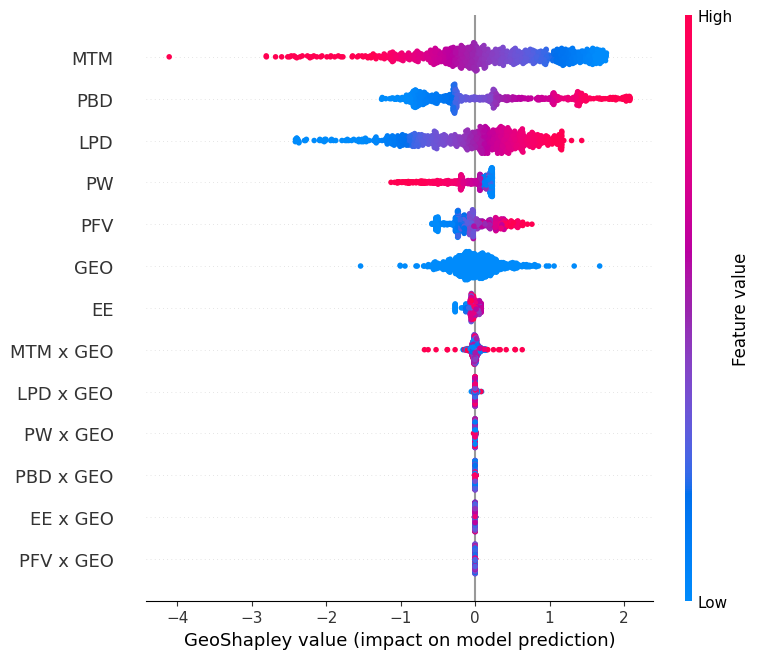

In [ ]:
import matplotlib.pyplot as plt
gpr_rslt.summary_plot(dpi=100)
plt.savefig('/picture/summary_plot.png', dpi=400)

In [ ]:
pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


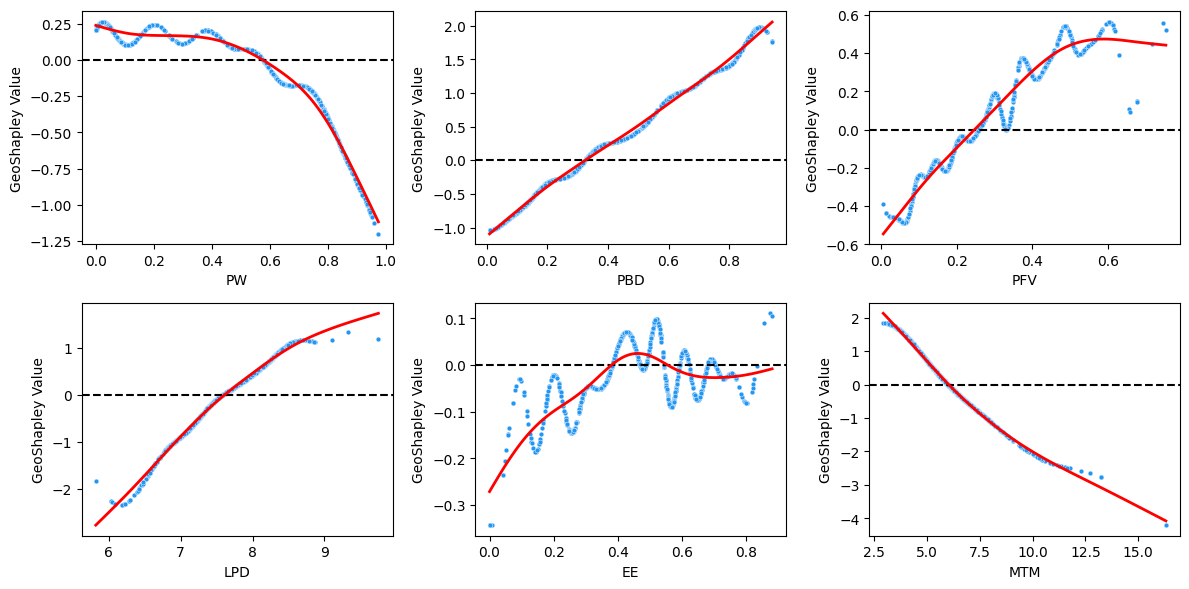

In [ ]:
gpr_rslt.partial_dependence_plots(figsize=(12,6),max_cols=3,gam_curve=True)
plt.savefig('/picture/pdp_c.png', dpi=400)

In [ ]:
gpr_rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
MTM,-4.203184,-0.357166,0.158790,0.977624,1.850769,0.217163,0.972724,0.790717
PBD,-1.038154,-0.618387,-0.195782,0.814494,1.976398,0.105601,0.846319,0.704520
LPD,-2.325635,-0.576414,0.097182,0.463634,1.339208,-0.062132,0.764734,0.607770
PW,-1.198826,-0.249695,0.072533,0.201956,0.261139,-0.082354,0.340311,0.269494
PFV,-0.489658,-0.208203,-0.036790,0.268371,0.562180,0.013264,0.284486,0.238214
MTM x GEO,-1.654205,-0.105216,-0.009194,0.105884,1.396044,0.001579,0.223470,0.152981
EE,-0.342933,-0.062504,-0.024248,0.020960,0.110822,-0.026537,0.073636,0.057323
GEO,-0.313084,-0.035848,-0.001796,0.029411,0.395978,-0.000885,0.074092,0.050392
LPD x GEO,-0.364708,-0.026053,-0.002353,0.024084,0.743710,0.000749,0.085137,0.049372
PW x GEO,-0.284655,-0.016580,-0.001329,0.016333,0.121920,0.000123,0.033406,0.023628


In [ ]:
shap_values = gpr_rslt.geoshap_to_shap()
X_names= ['PW','PBD','PFV','LPD','EE','MTM']

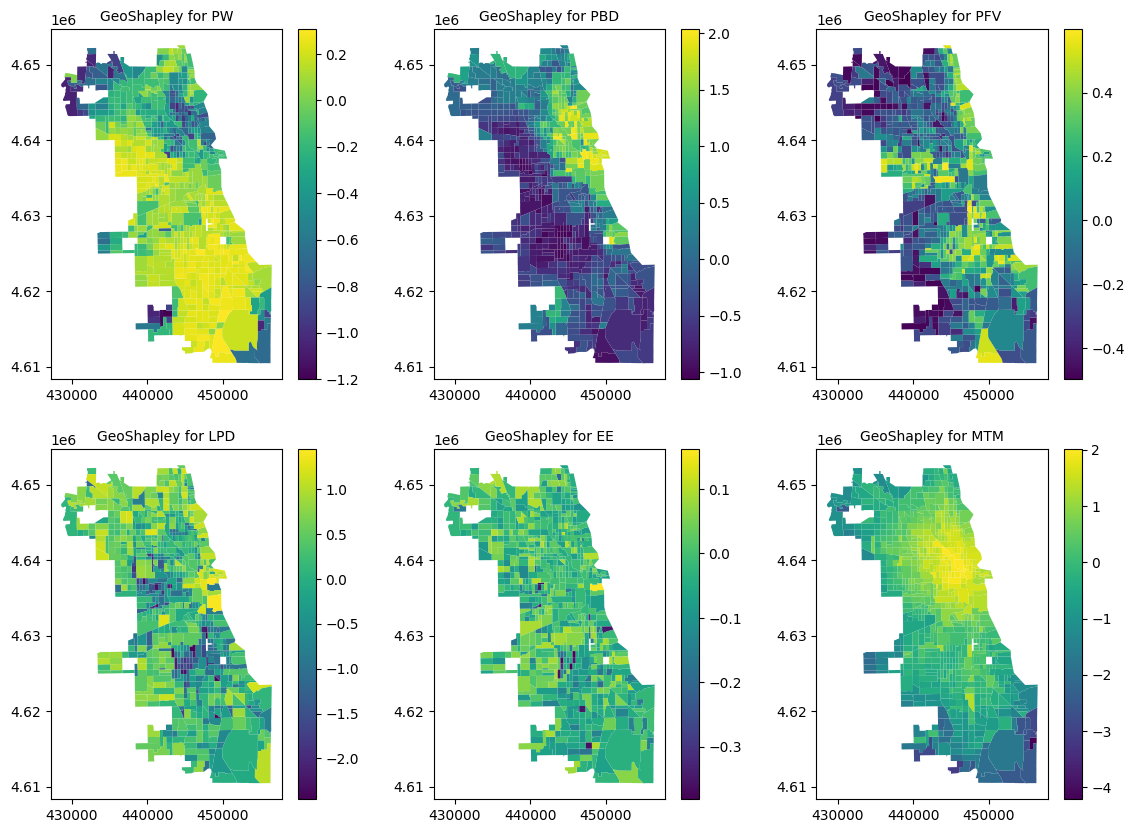

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(14,10))

for j in range(len(X_names)):
    ax = ax.ravel()
    chicago.plot(ax=ax[j],column = shap_values[:,j],legend=True,
                 cmap='viridis', legend_kwds={'shrink': 1})
    ax[j].set_title("GeoShapley for " + X_names[j],fontsize=10)

plt.savefig('/picture/featrue_e1.png', dpi=400)